In [27]:
df_sinai = pd.read_csv("../mount-sinai-vaccine/sinai-vaccine-peptides-v1-04-15-2020.csv")

In [28]:
df_sinai

,Name,Sequence,Start,End,Length,Domain,Glycosylation,Polymorphism,PEPperPRINT\nEpitope,PEPperPRINT \nIgG,PEPperPRINT\n IgA,Wang 2020,Poh 2020 Epitope,Notes,MHC-II epitopes
0,S453-15mer,YRLFRKSNLKPFERD,453,467,15,RBM,NaN,NaN,453-YRLFRKSNLKPFERD-467,1 strong,1 weak,Contains:\n456-FRKSN-460,NaN,Only in 2nd PEPperPRINT spreadsheet\n(single p...,NaN
1,S459-15mer,SNLKPFERDISTEIY,459,473,15,RBM,NaN,NaN,459-SNLKPFERDISTEIY-473,3,2,2aa overlap with:\n456-FRKSN-460,NaN,original PEPperPRINT spreadsheet hit,NaN
2,S505-18mer,YQPYRVVVLSFELLHAPA,505,522,18,RBD,NaN,NaN,505-YQPYRVVVLSFELLH-519,2,2,NaN,NaN,have MHC-II epitopes on the right,Multiple NetMHCIIpan 3.2 binding predictions\n...
3,S569-19mer,IADTTDAVRDPQTLEILDI,569,587,19,28aa downsteam\n of RBD,NaN,NaN,"569-IADTTDAVRDPQTLE-583, \n571-DTTDAVRDPQTLEIL...",3,1,NaN,NaN,made of 3 overlapping PEPperPRINT epitopes,NaN
4,S553-Neutralizing-S14P5-18mer,TESNKKFLPFQQFGRDIA,553,570,18,12aa downstream\nof RBD,NaN,NaN,NaN,NaN,NaN,NaN,Exact match:\n553-TESNKKFLPFQQFGRDIA-570,NaN,NaN
5,S806-Neutralizing-S21P2-21mer,LPDPSKPSKRSFIEDLLFNKV,806,826,21,C terminus of\nfusion peptide \n(FP),NaN,NaN,Contains:\n807-PDPSKPSKRSFIEDL-821,2,0,Contains:\n806-LPDPSKPSKRSFIED-820,Contains:\n809-PSKPSKRSFIEDLLFNKV-826,Extended Poh 2020 neutralizing anitibody epito...,NaN


In [29]:
df_solvent = pd.read_csv("relative-solvent-accessibility-6VXX.csv")

In [30]:
df_solvent

,resiNum,resiName,ASA,relative_solvent_accessibility
0,27,ALA,79.020000,0.612558
1,28,TYR,141.200000,0.536882
2,29,THR,13.620000,0.079186
3,30,ASN,56.733333,0.290940
4,31,SER,0.503333,0.003247
...,...,...,...,...
967,1143,PRO,54.200000,0.340881
968,1144,GLU,127.730000,0.572780
969,1145,LEU,125.193333,0.622852
970,1146,ASP,106.213333,0.550328


In [36]:
from collections import OrderedDict, defaultdict

all_possible_positions = set(range(1, df_solvent.resiNum.max()))
positions_in_model = set(df_solvent.resiNum)
missing_positions = all_possible_positions.difference(positions_in_model)


pos_to_residue_name = {resiNum: resiName for resiNum, resiName in zip(df_solvent.resiNum, df_solvent.resiName)}
pos_to_asa = {resiNum: asa for resiNum, asa in zip(df_solvent.resiNum, df_solvent.ASA)}
pos_to_rsa = {resiNum: rsa for resiNum, rsa in zip(df_solvent.resiNum, df_solvent.relative_solvent_accessibility)}

new_columns = OrderedDict([
    ("resiNum", []),
    ("resiName", []),
    ("ASA", []),
    ("relative_solvent_accessibility", []),
    ("missing", []),
    ("vaccine_peptide_names", []),
    ("in_vaccine_peptide", []),
    ("residue_description", []),
])

pos_to_vaccine_peptide_names = defaultdict(list)

for vaccine_peptide_name, start, end in zip(df_sinai.Name, df_sinai.Start, df_sinai.End):
    for pos in range(start, end + 1):
        pos_to_vaccine_peptide_names[pos].append(vaccine_peptide_name)
    
for pos in sorted(all_possible_positions):
 
    if pos in pos_to_residue_name:
        residue_name = pos_to_residue_name[pos]
        asa = pos_to_asa[pos]
        rsa = pos_to_rsa[pos]
        missing = False
    else:
        residue_name = "?"
        asa = 0
        rsa = 0
        missing = True
    vaccine_peptide_names = pos_to_vaccine_peptide_names[pos]
    in_vaccine_peptide = len(vaccine_peptide_names) > 0
    if in_vaccine_peptide and missing:
          description = "vaccine + missing"
    elif in_vaccine_peptide:
        description = "vaccine"
    elif missing:
        description = "missing"
    else:
        description = "not vaccine"
    
    new_columns["resiNum"].append(pos)
    new_columns["resiName"].append(residue_name)
    new_columns["ASA"].append(asa)
    new_columns["relative_solvent_accessibility"].append(rsa)
    new_columns["missing"].append(missing)
    new_columns["vaccine_peptide_names"].append(tuple(sorted(vaccine_peptide_names)))
    new_columns["in_vaccine_peptide"].append(in_vaccine_peptide)
    new_columns["residue_description"].append(description)

df = pd.DataFrame(new_columns)
df["num_vaccine_peptides"] = df["vaccine_peptide_names"].map(len)

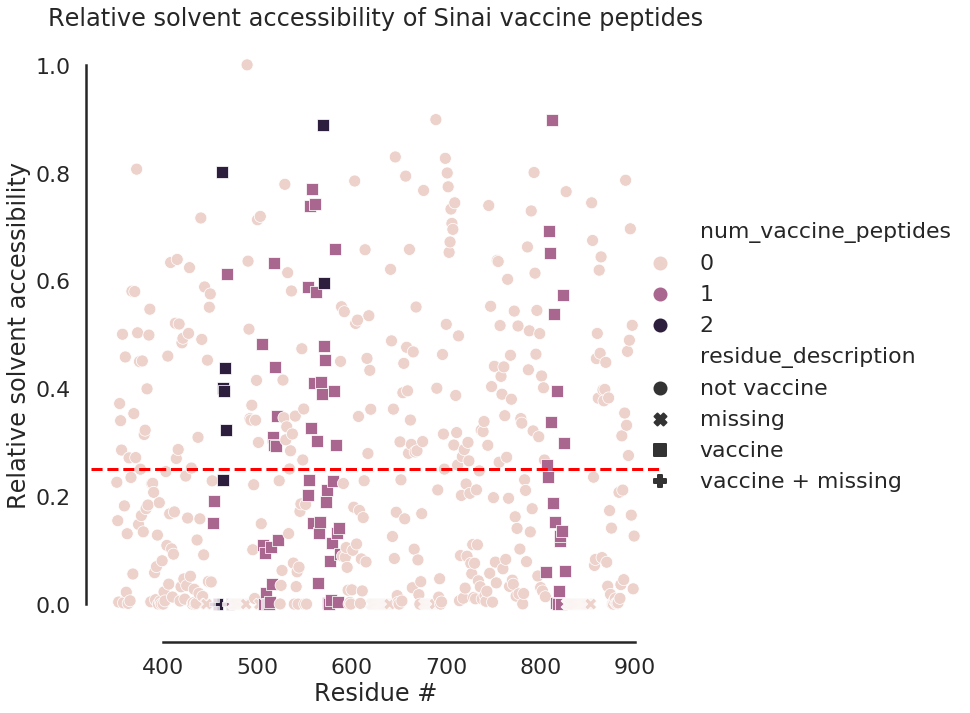

In [67]:

%matplotlib inline
import seaborn
import matplotlib.pyplot as plt


with seaborn.axes_style("white"), seaborn.plotting_context("poster"):
    g = seaborn.relplot(
        data=df[(df.resiNum >350) & (df.resiNum < 900)], 
        x="resiNum", y="relative_solvent_accessibility",
        height=10,
        hue="num_vaccine_peptides",
        style="residue_description")
    seaborn.despine(offset=5, trim=True);
    plt.xlabel("Residue #")
    plt.ylabel("Relative solvent accessibility")
    plt.title("Relative solvent accessibility of Sinai vaccine peptides")
    ax = g.axes[0][0]
    ax.axhline(0.25, ls='--', color="red")
    g.savefig("sinai-vaccine-peptide-solvent-accessibility.png")


In [66]:
len(df_solvent[(df_solvent.resiNum >300) & (df_solvent.resiNum < 900)])

511